<a href="https://colab.research.google.com/github/vimalthomas/deeplearning/blob/main/MLP_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import Tuple


def batch_generator(train_x, train_y, batch_size):
    indices = np.arange(len(train_x))
    np.random.shuffle(indices)  # Shuffle indices

    for i in range(0, len(train_x), batch_size):
        batch_idx = indices[i:i+batch_size]
        batch_x = train_x[batch_idx]
        batch_y = train_y[batch_idx]
        yield batch_x, batch_y






class ActivationFunction(ABC):
    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the output of the activation function, evaluated on x

        Input args may differ in the case of softmax

        :param x (np.ndarray): input
        :return: output of the activation function
        """
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the derivative of the activation function, evaluated on x
        :param x (np.ndarray): input
        :return: activation function's derivative at x
        """
        pass


class Sigmoid(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x) * (1 - self.forward(x))




class Tanh(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(x) ** 2


class Relu(ActivationFunction):
  def forward(self, x: np.ndarray) -> np.ndarray:
    return np.maximum(0, x)  # ReLU function: max(0, x)

  def derivative(self, x: np.ndarray) -> np.ndarray:
    return (x > 0).astype(float)  # Derivative: 1 for x > 0, else 0


class Softmax(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the Softmax activation function.
        Uses a stability trick to prevent overflow.

        :param x: Input logits (batch_size, num_classes)
        :return: Softmax probabilities (batch_size, num_classes)
        """
        x_max = np.max(x, axis=-1, keepdims=True)  # Stability trick
        exp_x = np.exp(x - x_max)
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the Jacobian matrix of Softmax for each sample in the batch.

        :param x: Softmax output (batch_size, num_classes)
        :return: Jacobian matrix (batch_size, num_classes, num_classes)
        """
        batch_size, num_classes = x.shape
        jacobian_matrix = np.zeros((batch_size, num_classes, num_classes))

        for i in range(batch_size):
            s_i = x[i].reshape(-1, 1)  # Convert to column vector
            jacobian_matrix[i] = np.diagflat(s_i) - np.dot(s_i, s_i.T)  # Softmax Jacobian

        return jacobian_matrix




class Linear(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return x

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.ones_like(x)

class Softplus(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.log(1 + np.exp(x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))  # Sigmoid function


class Mish(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return x * np.tanh(np.log1p(np.exp(x)))  # log1p for numerical stability

    def derivative(self, x: np.ndarray) -> np.ndarray:
        softplus_x = np.log1p(np.exp(x))
        tanh_softplus = np.tanh(softplus_x)
        return tanh_softplus + x * (1 - tanh_softplus ** 2) * (1 / (1 + np.exp(-x)))


class LossFunction(ABC):
    @abstractmethod
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        pass


class SquaredError(LossFunction):
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return 1/2 * np.square(y_pred-y_true)

    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (y_pred - y_true)/y_pred.shape[0]


class CrossEntropy(LossFunction):
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -y_true / y_pred

class BinaryCrossEntropy(LossFunction):
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Computes binary cross-entropy loss
        """
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Prevent log(0) issues
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Computes gradient of binary cross-entropy loss
        """
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return (y_pred - y_true) / (y_pred * (1 - y_pred) * len(y_true))





class Layer:
    def __init__(self, fan_in: int, fan_out: int, activation_function: ActivationFunction):
        """
        Initializes a layer of neurons

        :param fan_in: number of neurons in previous (presynpatic) layer
        :param fan_out: number of neurons in this layer
        :param activation_function: instance of an ActivationFunction
        """
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.activation_function = activation_function

        # this will store the activations (forward prop)
        self.activations = None
        # this will store the delta term (dL_dPhi, backward prop)
        self.delta = None

        # Initialize weights and biaes
        # self.W = None  # weights
        # self.b = None  # biases

        #note to self. looks like He initialization will help relu function
        #come back later

        #self.W = np.random.randn(fan_in, fan_out) * 0.01
        self.W = np.random.randn(fan_in, fan_out) * np.sqrt(2.0 / fan_in)  # He_init for Relu

        self.b = np.zeros((fan_out,))

    def forward(self, h: np.ndarray):
        """
        Computes the activations for this layer

        :param h: input to layer
        :return: layer activations
        """
        #Z calculation

        Z = np.dot(h, self.W) + self.b
        #self.activations = None
        self.activations = self.activation_function.forward(Z)
        return self.activations




    # def backward(self, h: np.ndarray, delta: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    #     """
    #     Apply backpropagation to this layer and return the weight and bias gradients

    #     :param h: input to this layer
    #     :param delta: delta term from layer above
    #     :return: (weight gradients, bias gradients)
    #     """

    #     #compute dZ
    #     dZ = delta * self.activation_function.derivative(self.activations)
    #     #compute dW, db

    #     dL_dW = np.dot(h.T, dZ) / h.shape[0]
    #     dL_db = np.sum(dZ, axis=0) / h.shape[0]


    #     self.delta = dZ
    #     return dL_dW, dL_db

    def backward(self, h: np.ndarray, delta: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
      """
      Apply backpropagation to this layer and return the weight and bias gradients.

      :param h: Input to this layer.
      :param delta: Delta term from the layer above.
      :return: (Weight gradients, Bias gradients).
      """
      if isinstance(self.activation_function, Softmax):

        # Compute the Softmax derivative using the Jacobian
        softmax_out = self.activations  # Already computed during forward pass
        softmax_jacobian = self.activation_function.derivative(softmax_out)  # Shape (batch_size, num_classes, num_classes)

        # Multiply Jacobian by delta (loss gradient w.r.t. activations)
        dZ = np.einsum('bij,bj->bi', softmax_jacobian, delta)  # Efficient batch-wise multiplication
      else:
        dZ = delta * self.activation_function.derivative(self.activations)

    # Compute weight and bias gradients
      dL_dW = np.dot(h.T, dZ) / h.shape[0]  # (fan_in, fan_out)
      dL_db = np.sum(dZ, axis=0, keepdims=True) / h.shape[0]  # (1, fan_out)

      self.delta = np.dot(dZ, self.W.T)  # (batch_size, fan_in)

      return dL_dW, dL_db




class MultilayerPerceptron:
    def __init__(self, layers: Tuple[Layer]):
        """
        Create a multilayer perceptron (densely connected multilayer neural network)
        :param layers: list or Tuple of layers
        """
        self.layers = layers

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        This takes the network input and computes the network output (forward propagation)
        :param x: network input
        :return: network output
        """

        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, loss_grad: np.ndarray, input_data: np.ndarray) -> Tuple[list, list]:
      """
      Applies backpropagation to compute gradients of weights and biases for all layers in the network.

      :param loss_grad: Gradient of loss w.r.t. final layer output (dL/dA).
      :param input_data: The input data to the network (train_x for the first layer).
      :return: (List of weight gradients for all layers, List of bias gradients for all layers).
      """

      dl_dw_all = []
      dl_db_all = []

      dL_dA = loss_grad  # Start with gradient from the loss function

    # Iterate backward through layers
      for i in reversed(range(len(self.layers))):
        layer = self.layers[i]

        # Get the correct input for this layer
        if i == 0:
            h = input_data  # First layer gets train_x
        else:
            h = self.layers[i - 1].activations  # Other layers get activations from previous layer

        # Compute backpropagation step for this layer
        dL_dW, dL_db = layer.backward(h, dL_dA)

        # Store gradients
        dl_dw_all.append(dL_dW)
        dl_db_all.append(dL_db)

        dL_dA = layer.delta  # Update delta for the next layer

    # Reverse lists to match layer order
      dl_dw_all.reverse()
      dl_db_all.reverse()

      return dl_dw_all, dl_db_all














    def train(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray, val_y: np.ndarray, loss_func: LossFunction, learning_rate: float=1E-3, batch_size: int=16, epochs: int=32) -> Tuple[np.ndarray, np.ndarray]:
        """
        Train the multilayer perceptron

        :param train_x: full training set input of shape (n x d) n = number of samples, d = number of features
        :param train_y: full training set output of shape (n x q) n = number of samples, q = number of outputs per sample
        :param val_x: full validation set input
        :param val_y: full validation set output
        :param loss_func: instance of a LossFunction
        :param learning_rate: learning rate for parameter updates
        :param batch_size: size of each batch
        :param epochs: number of epochs
        :return:
        """

        #define the epoch loop

        training_losses = []
        validation_losses = []


        #defin epoch loop

        for epoch in range(epochs):

          #define batch loop
          total_loss = 0

          for batch_x, batch_y in batch_generator(train_x, train_y, batch_size):


            #forward pass
            y_pred = self.forward(batch_x)

            #compute loss

            batchloss = loss_func.loss(batch_y, y_pred)
            total_loss = total_loss + np.mean(batchloss)

            #print(total_loss)


            #backward pass and compute gradianet
            #dL_dW, dL_db  = self.backward(loss_func.derivative(batch_y, output), batch_x)
            dL_dW, dL_db  = self.backward(loss_func.derivative(batch_y[:len(y_pred)], y_pred), batch_x)


            #update weights
            max_grad_norm = 1.0  # Limits the maximum gradient value



            for i in range(len(self.layers)):
              # Clip gradients
              dL_dW[i] = np.clip(dL_dW[i], -max_grad_norm, max_grad_norm)
              dL_db[i] = np.clip(dL_db[i], -max_grad_norm, max_grad_norm)

              self.layers[i].W -= learning_rate * dL_dW[i]
              #self.layers[i].b -= learning_rate * dL_db[i]
              #self.layers[i].b -= learning_rate * np.array(dL_db[i]).flatten()
              self.layers[i].b -= learning_rate * dL_db[i].squeeze()






          training_losses.append(total_loss / len(train_x))

          # Compute Validation Loss
          val_output = self.forward(val_x)
          val_loss = loss_func.loss(val_y, val_output)
          validation_losses.append(np.mean(val_loss))

          # Compute training accuracy at the end of the epoch
          train_acc = compute_accuracy(self, train_x, train_y)
          val_acc = compute_accuracy(self, val_x, val_y)

          #print(f"dL_dW max: {np.max([np.max(w) for w in dL_dW])}, min: {np.min([np.min(w) for w in dL_dW])}")
          #print(f"dL_db max: {np.max([np.max(b) for b in dL_db])}, min: {np.min([np.min(b) for b in dL_db])}")

          print(f"Epoch {epoch+1}/{epochs} - Training Loss: {total_loss:.4f} - Training Acc: {train_acc:.2f}% - Validation Acc: {val_acc:.2f}% - Validation Loss: {validation_losses[-1]:.4f}")








        return training_losses, validation_losses

def compute_accuracy(model, X, y):
    """
    Compute accuracy of the model.

    :param model: The trained MLP model
    :param X: Input features (numpy array)
    :param y: True labels (numpy array)
    :return: Accuracy in percentage (%)
    """
    y_pred = model.forward(X)  # Forward pass
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to 0 or 1
    accuracy = np.mean(y_pred_binary == y) * 100  # Compute accuracy

    return accuracy

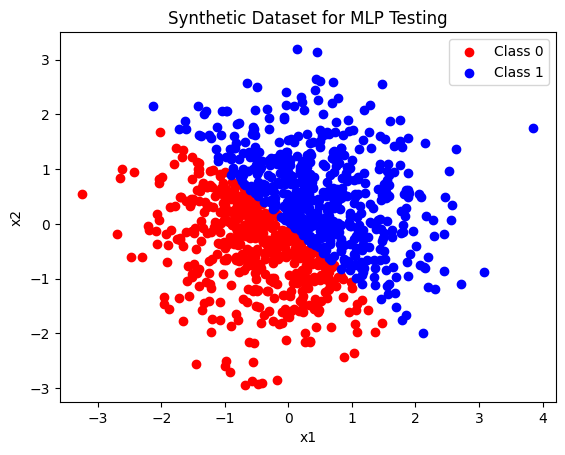

Class distribution: {0: 382, 1: 418}


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)


# Generate synthetic data
num_samples = 1000

# Features: x1 and x2 sampled from normal distribution
x1 = np.random.randn(num_samples)
x2 = np.random.randn(num_samples)

# Labels: 1 if x1 + x2 > 0, else 0
y = (x1 + x2 > 0).astype(int)

# Stack features into input matrix
X = np.column_stack((x1, x2))
Y = y.reshape(-1, 1)  # Convert to column vector

# Split into train and validation sets
split = int(0.8 * num_samples)
train_x, val_x = X[:split], X[split:]
train_y, val_y = Y[:split], Y[split:]

# Plot the dataset
plt.scatter(x1[y == 0], x2[y == 0], color='red', label='Class 0')
plt.scatter(x1[y == 1], x2[y == 1], color='blue', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic Dataset for MLP Testing')
plt.legend()
plt.show()

unique, counts = np.unique(train_y, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")


In [6]:
# Create an MLP model
layers = [
    Layer(fan_in=2, fan_out=8, activation_function=Relu()),  # Hidden layer with 4 neurons
    Layer(fan_in=8, fan_out=8, activation_function=Relu()),  # Hidden layer with 4 neurons
    Layer(fan_in=8, fan_out=1, activation_function=Sigmoid()) # Output layer with 1 neuron
]

mlp = MultilayerPerceptron(layers)

# Train the model
loss_function = BinaryCrossEntropy()
train_losses, val_losses = mlp.train(
    train_x=train_x, train_y=train_y,
    val_x=val_x, val_y=val_y,
    loss_func=loss_function,
    learning_rate=0.01, batch_size=32, epochs=1000
)



Epoch 1/1000 - Training Loss: 17.8600 - Training Acc: 47.75% - Validation Acc: 47.00% - Validation Loss: 0.6888
Epoch 2/1000 - Training Loss: 17.6867 - Training Acc: 48.12% - Validation Acc: 47.00% - Validation Loss: 0.6823
Epoch 3/1000 - Training Loss: 17.5166 - Training Acc: 48.38% - Validation Acc: 47.00% - Validation Loss: 0.6761
Epoch 4/1000 - Training Loss: 17.3609 - Training Acc: 48.50% - Validation Acc: 48.00% - Validation Loss: 0.6702
Epoch 5/1000 - Training Loss: 17.2105 - Training Acc: 49.00% - Validation Acc: 48.00% - Validation Loss: 0.6647
Epoch 6/1000 - Training Loss: 17.0707 - Training Acc: 49.62% - Validation Acc: 48.00% - Validation Loss: 0.6594
Epoch 7/1000 - Training Loss: 16.9347 - Training Acc: 49.62% - Validation Acc: 48.50% - Validation Loss: 0.6543
Epoch 8/1000 - Training Loss: 16.8066 - Training Acc: 49.75% - Validation Acc: 49.00% - Validation Loss: 0.6495
Epoch 9/1000 - Training Loss: 16.6852 - Training Acc: 50.38% - Validation Acc: 49.00% - Validation Loss:

<ipython-input-4-b4a18b382b35>:47: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 699/1000 - Training Loss: 2.5493 - Training Acc: 98.12% - Validation Acc: 98.00% - Validation Loss: 0.1126
Epoch 700/1000 - Training Loss: 2.5608 - Training Acc: 98.12% - Validation Acc: 98.50% - Validation Loss: 0.1067
Epoch 701/1000 - Training Loss: 2.5554 - Training Acc: 98.25% - Validation Acc: 98.50% - Validation Loss: 0.1052
Epoch 702/1000 - Training Loss: 2.4526 - Training Acc: 98.12% - Validation Acc: 98.00% - Validation Loss: 0.1089
Epoch 703/1000 - Training Loss: 2.5305 - Training Acc: 98.12% - Validation Acc: 98.00% - Validation Loss: 0.1097
Epoch 704/1000 - Training Loss: 2.4129 - Training Acc: 98.12% - Validation Acc: 98.00% - Validation Loss: 0.1151
Epoch 705/1000 - Training Loss: 2.6868 - Training Acc: 98.38% - Validation Acc: 98.50% - Validation Loss: 0.0974
Epoch 706/1000 - Training Loss: 2.3143 - Training Acc: 98.12% - Validation Acc: 98.00% - Validation Loss: 0.1067
Epoch 707/1000 - Training Loss: 2.4019 - Training Acc: 98.12% - Validation Acc: 98.00% - Validat